## Chiquito Or Not: Image Classification with FastAI

In this notebook, we are creating a **Chiquito* detector**. 
This is basically an Image Classification Task based on Convolutional Neural Networks

It is inspired by [fast.ai](http://fast.ai) Deep Learning Course, and it uses its library.
With this approach we are achieving an accuracy of 98% (only two misclassified images)


More info [in my blog](https://unmonoqueteclea.github.io/deep-learning/chiquito/) [IN SPANISH]

*For those who don´t know Chiquito de la Calzada is a famous spanish comedian known from some of his quotes such as:
- *“¡Al ataquer!”*
-  *“¿Cómor?”*
- *“Te da cuén”*

![Chiquito](https://elpais.com/elpais/imagenes/2017/11/08/gente/1510161845_248633_1510218349_noticia_fotograma.jpg)

## Basic configuration

___

In [0]:

#Uncomment this in case you want to reset Google Colab virtual machine
#!kill -9 -1

Installing library

---

In [0]:
!pip install fastai

Downloading dataset from [Github](https://github.com/unmonoqueteclea/DeepLearning-Notebooks/raw/master/ChiqutoOrNot/dataset.zip)

In [0]:
!mkdir data && wget https://github.com/unmonoqueteclea/DeepLearning-Notebooks/raw/master/ChiqutoOrNot/dataset.zip && unzip dataset.zip -d data/
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Importing dependencies

---

In [0]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [0]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

**size** variable will specify the image size used by our library

---

In [0]:
PATH = "data/dataset/"
size=224

Checking if we are using **GPU**

---

In [41]:
torch.cuda.is_available()

True

In [42]:
torch.backends.cudnn.enabled

True

Checking that we have the needed folders in our dataset: **valid** and **train**

---

In [43]:
os.listdir(PATH)

['models', 'valid', 'tmp', 'train']

We have to possible classes: **chiquito** and **not** (not chiquito)
Images in **not** comes from [Labeled Faces in the Wild dataset](http://vis-www.cs.umass.edu/lfw/#download)

We will show 

---



In [45]:
os.listdir(f'{PATH}valid')

['chiquito', 'not']

## Creating  and testing first classiffier

This is the first version of the classifier. We will use a preteined model: [resnet](https://arxiv.org/abs/1512.03385)

As we have a very small dataset, we will using a batch size of 8

First of all we will find the optimal **learning rate**
 It uses the technique developed in the 2015 paper [Cyclical Learning Rates for Training Neural Networks](http://arxiv.org/abs/1506.01186), where we simply keep increasing the learning rate from a very small value, until the loss stops decreasing


---

In [60]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz), bs=8)
learn = ConvLearner.pretrained(arch, data, precompute=True)
lrf=learn.lr_find()


 82%|████████▏ | 45/55 [00:00<00:00, 99.08it/s, loss=4.68] 


From the data of the graph bellow, we will use a maximum learning rate of 0.01

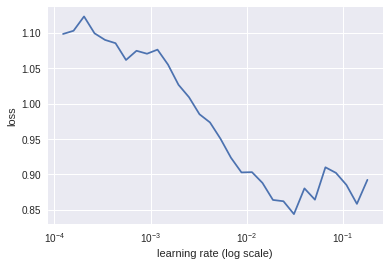

In [62]:
learn.sched.plot()

Now, we will train our network, with two batches and a learning rate of 0.01

___

In [63]:
learn.fit(0.01, 2)

epoch      trn_loss   val_loss   accuracy   
    0      0.75035    0.277269   0.89      
    1      0.57376    0.417518   0.92      



[array([0.41752]), 0.92]

## Analyzing results 
As we can see, we are obtaining an accuracy of 92%. Not a bad start point. However we are going to analyze the results now

___

In [0]:
# This gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)

### Creating useful functions for showing images

Functions taken from [fast.ai](http://fast.ai) Deep Learning Course

In [0]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [0]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [0]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

### Showing results

Correctly classified


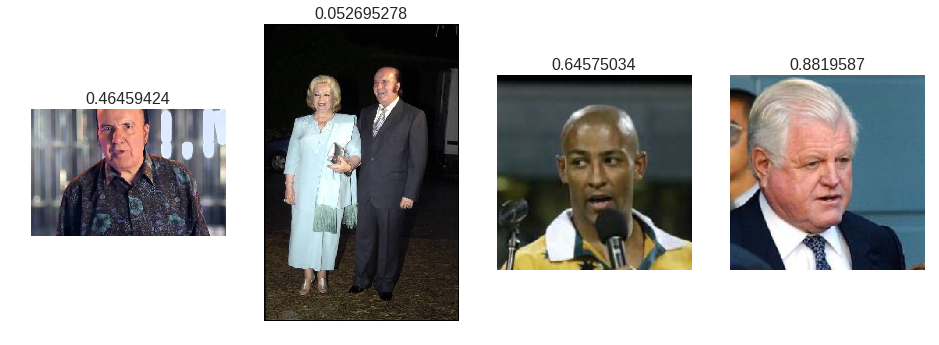

In [68]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


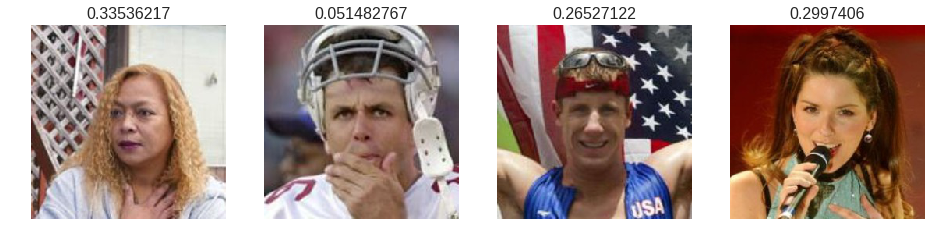

In [69]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

Most correct Chiquitos


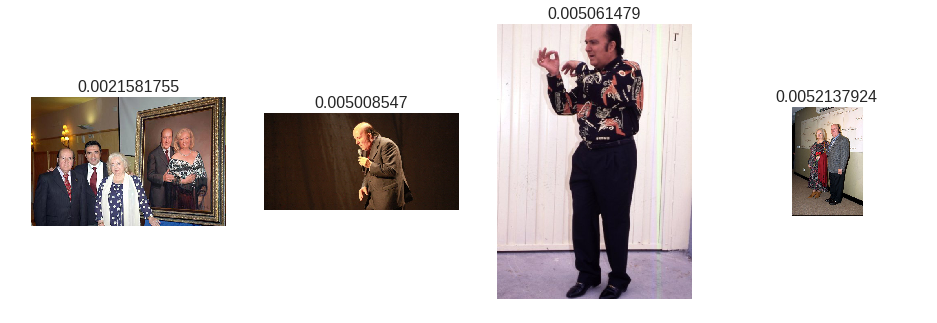

In [70]:
plot_val_with_title(most_by_correct(0, True), "Most correct Chiquitos")

Most correct NOT Chiquitos


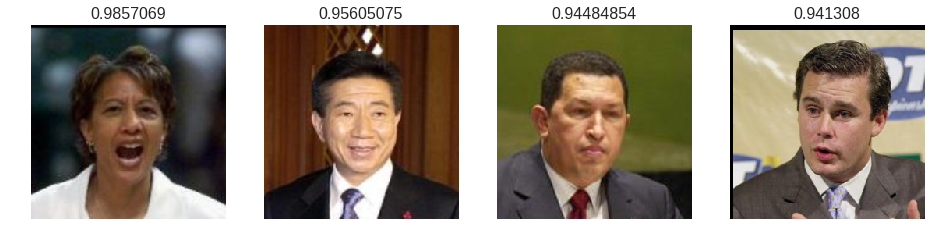

In [71]:
plot_val_with_title(most_by_correct(1, True), "Most correct NOT Chiquitos")

In [73]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect NOT Chiquitos")

Most incorrect NOT Chiquitos


Most incorrect Chiquitos


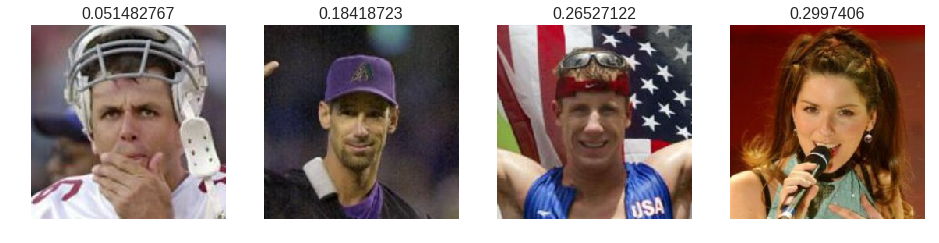

In [74]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect Chiquitos")

Most uncertain predictions


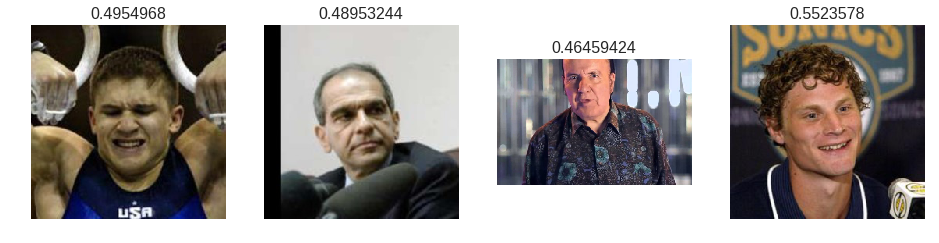

In [75]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

## Data Augmentation

We can avoid our model overfitting with **data augmentation**. This will randomly perform some basic operations on the images such us  horizontal flipping, zooming, and rotating. 

In [0]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.3)

In [0]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [0]:
ims = np.stack([get_augs() for i in range(6)])

Example of data augmentation

___

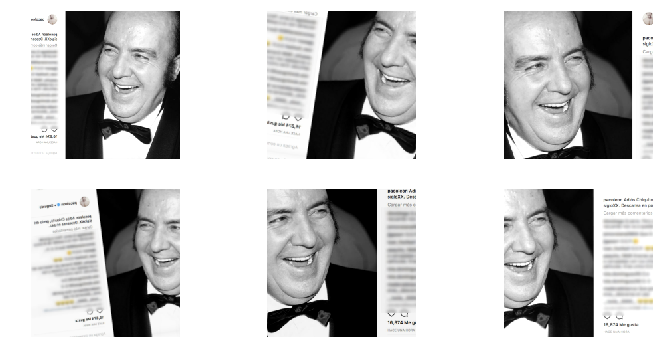

In [83]:
plots(ims, rows=2)

## Creating and testing second and thrid classifiers

Now we will create and test our second and third classifiers, that we will use the aumented dataset.
The first one, will use again the frozen model (so it will only train the last layer).

In [86]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=False)
learn.fit(1e-2, 4, cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      0.82408    0.574495   0.74      
    1      0.686055   0.363536   0.89      
    2      0.599004   0.247279   0.93      
    3      0.521594   0.201349   0.95      



[array([0.20135]), 0.9499999952316284]

Saving the model

___

In [0]:
learn.save('224_lastlayer')
learn.load('224_lastlayer')

Now that we have a good final layer trained, we are going to try **fine-tuning** the previous layers

In [0]:
learn.unfreeze()

We are using different learning rates for each layer, because we want to conserve some of the knowledge of previous layers. As we know, first layer have more general information, so we want them to change so much

___

In [0]:
lr=np.array([1e-4,1e-3,1e-2])

Now, we are training our third classifier that trains the unfreeze model.

___

In [92]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy   
    0      0.433208   0.203121   0.94      
    1      0.351569   0.12139    0.96      
    2      0.286359   0.111225   0.96      
    3      0.25099    0.071037   0.97      
    4      0.213535   0.056884   0.98      
    5      0.185564   0.053942   0.98      
    6      0.165624   0.055302   0.98      



[array([0.0553]), 0.98]

We have achieve a **98% of accuracy!** As we have few images in our dataset, this is a very good result!
We will save the model

___

In [0]:
learn.save('224_all')
learn.load('224_all')

## Test Time Data Augmentation

Now, we will apply a not very known technique known as **Test Time Data Augmentation (TTA)**. 

TTA simply makes predictions not just on the images in your validation set, but also makes predictions on a number of randomly augmented versions of them too (by default, it uses the original image along with 4 randomly augmented versions). It then takes the average prediction from these images, and uses that. To use TTA on the validation set, we can use the learner's TTA() method.

In [96]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y)

0.98

## Final Analysis

We will analyze our results now

### Confussion matrix

In [0]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[48  2]
 [ 0 50]]


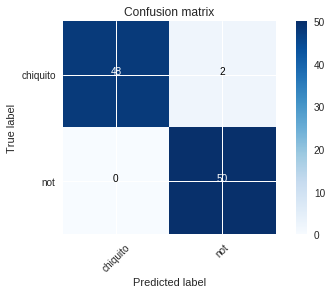

In [98]:
plot_confusion_matrix(cm, data.classes)

We only have two misclisified examples, let´s see them:

___

Incorrectly classified


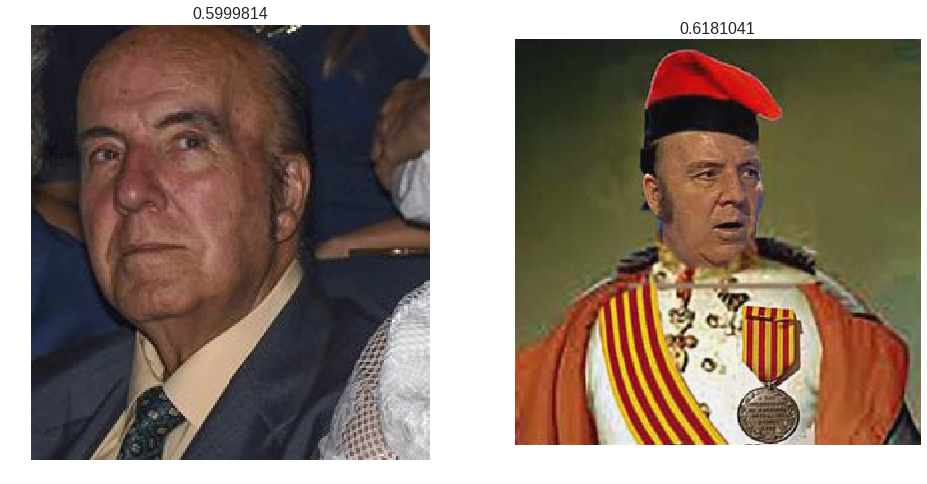

In [100]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 2, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")